# Seed Classification and Segmentation Demo

This notebook demonstrates the pipeline for seed classification and segmentation:
1. Feature extraction
2. Model training
3. Segmentation and classification

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from feature_extraction import extract_contour_features, compute_contours
import random_forest_train 
import svm_train
from segmentation import pipeline
import joblib
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
PATH = 'SIV_dataset/Cropped/'  #<#
FEATURE_FILE = 'features.csv'
MODEL = 'classifier.pkl'
TEST_FOLDER = 'SIV_dataset/Test/'

## 1. Feature Extraction

First, we'll extract features from our training images.

In [2]:
df = pd.DataFrame(columns=['label','area', 'perimeter', 'aspect_ratio', 'circularity', 'mean_color_b', 'mean_color_g', 'mean_color_r'])

## all images are in this folder, check them all
subdirectories = os.listdir(PATH)
#filter out files
subdirectories = [subdir for subdir in subdirectories if os.path.isdir(os.path.join(PATH, subdir))]

for subdir in tqdm(subdirectories,desc='Processing Folder', position=0):
    images = os.listdir(os.path.join(PATH, subdir))
    images = [img for img in images if img.endswith('.jpg')]
    for filename in tqdm(images,desc='Processing Image', position=1):
        file_path = os.path.join(PATH, subdir, filename)
        img=cv.imread(file_path)
        img = cv.resize(img, (64, 64))
        contour = compute_contours(img.copy())
        feature_dict = extract_contour_features(img=img,contour=contour)
        #keypoint_features(img=combined)
        
        for key in feature_dict:
            feature_dict[key] = round(feature_dict[key], 2)
        new_row = {'label': subdir, **feature_dict}
        #check if df is empty
        if df.empty:
            df = pd.DataFrame([new_row])
        else: df = pd.concat([df, pd.DataFrame([new_row])])
df.to_csv(FEATURE_FILE, index=False)
print("Features shape:", df.shape)
print("\nUnique classes:", df['label'].unique())
print("\nFeature columns:", df.columns.tolist()[:10], "...")

Processing Folder:   0%|          | 0/5 [00:00<?, ?it/s]

Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

Features shape: (100, 786)

Unique classes: ['oats' 'lentils' 'chickpeas' 'barley' 'beans']

Feature columns: ['label', 'circularity', 'mean_color_b', 'mean_color_g', 'mean_color_r', 'radius', 'extent', 'normalized_radius', 'normalized_area', 'normalized_perimeter'] ...


## 2. Train a classifier

Accuracy: 0.9


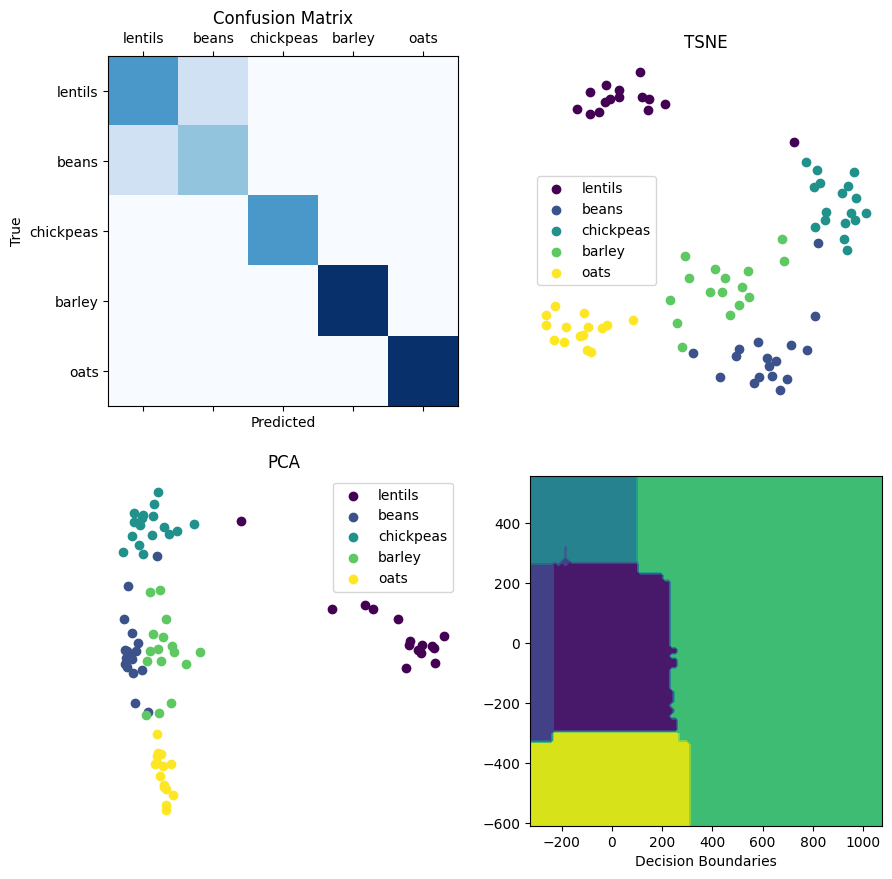

In [3]:
df = pd.read_csv(FEATURE_FILE)
feature_vectors = df.drop('label', axis=1).values
labels = df['label'].values

X = np.array(feature_vectors)  # Feature vectors
y = np.array(labels)  # Labels for the seeds
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train Random Forest Classifier
classifier = random_forest_train.forest_train(X_train, y_train)
#classifier = svm_train.train_svm(X_train, y_train)
accuracy = classifier.score(X_test, y_test)
print(f'Accuracy: {accuracy}')
joblib.dump(classifier, MODEL)
random_forest_train.plot_info(X_train, y_train, y_test, X_test, classifier)

## 3. Segmentation and Classification

Now let's test the pipeline on both easy and hard images.

Processing Easy images
These image have a white background and the seeds are clearly visible


Processing contours:   0%|          | 0/13 [00:00<?, ?it/s]

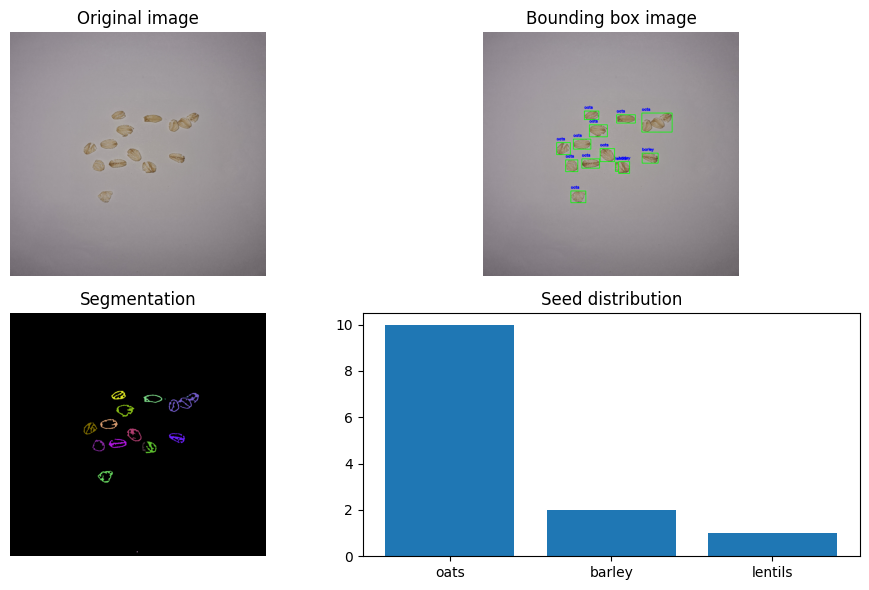

Processing contours:   0%|          | 0/50 [00:00<?, ?it/s]

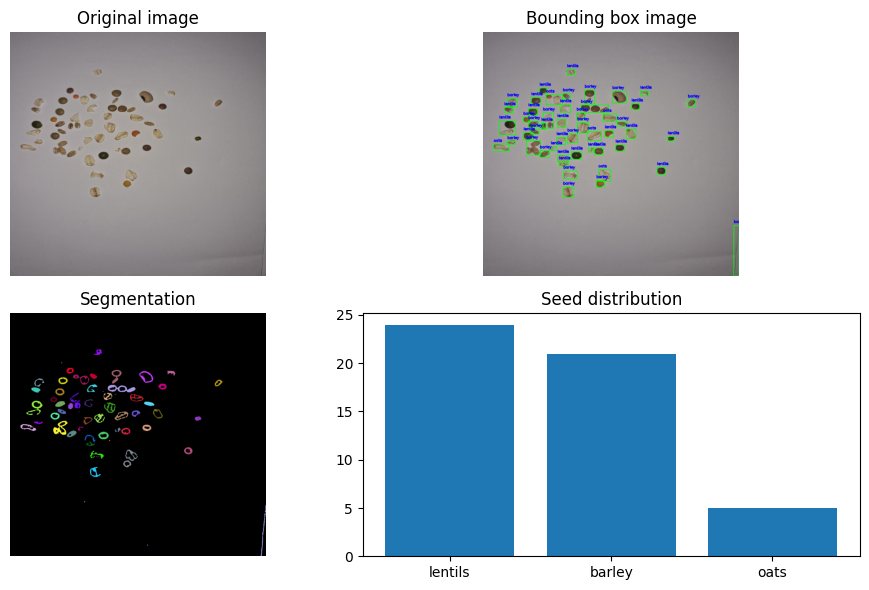

Processing contours:   0%|          | 0/8 [00:00<?, ?it/s]

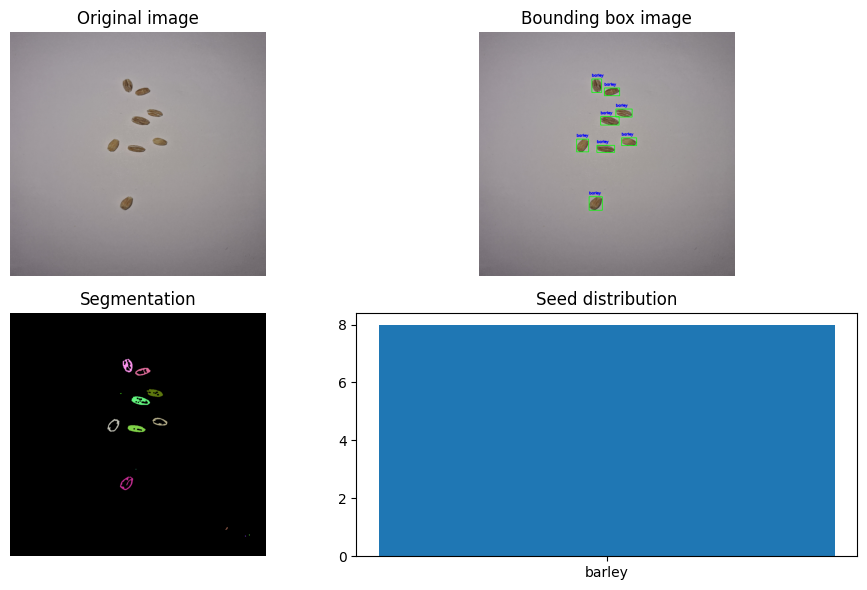

Processing contours:   0%|          | 0/10 [00:00<?, ?it/s]

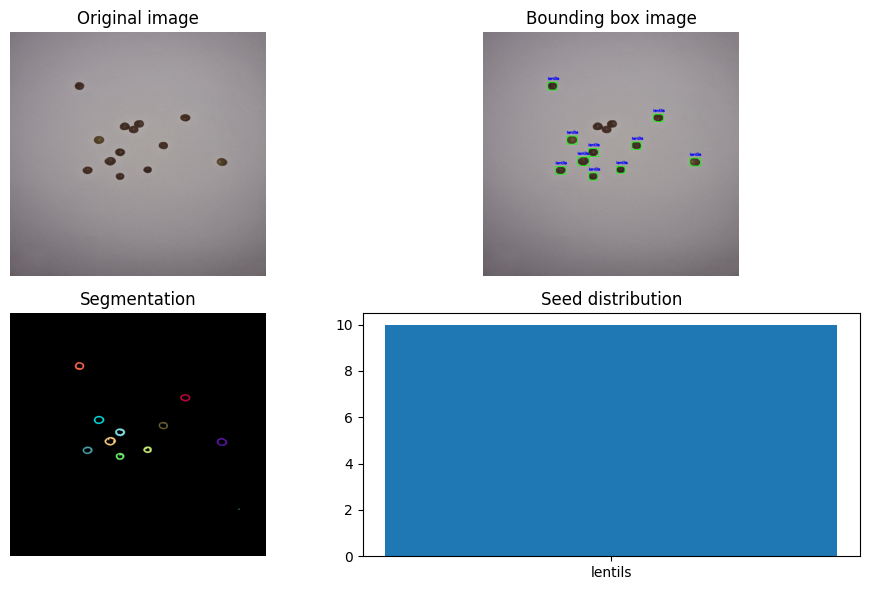

Processing contours:   0%|          | 0/10 [00:00<?, ?it/s]

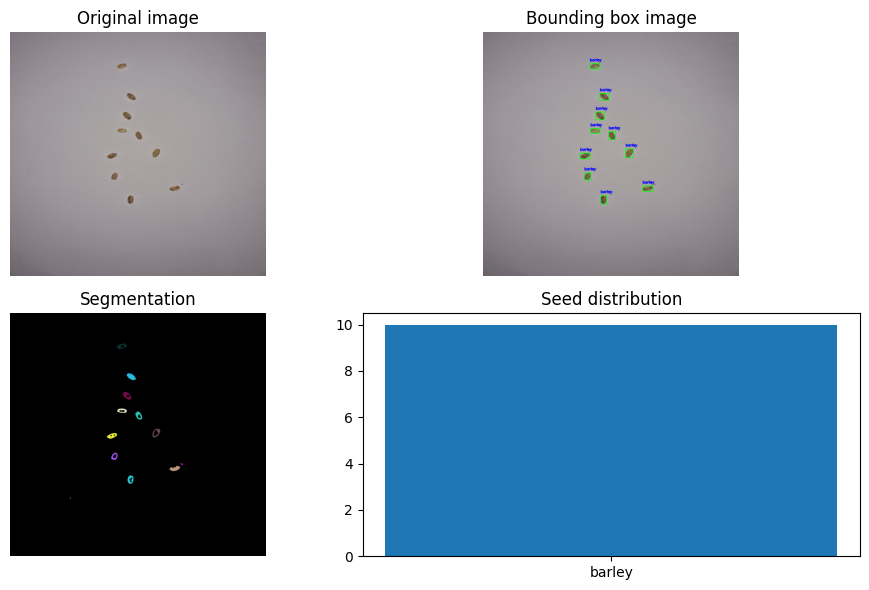

Processing contours:   0%|          | 0/9 [00:00<?, ?it/s]

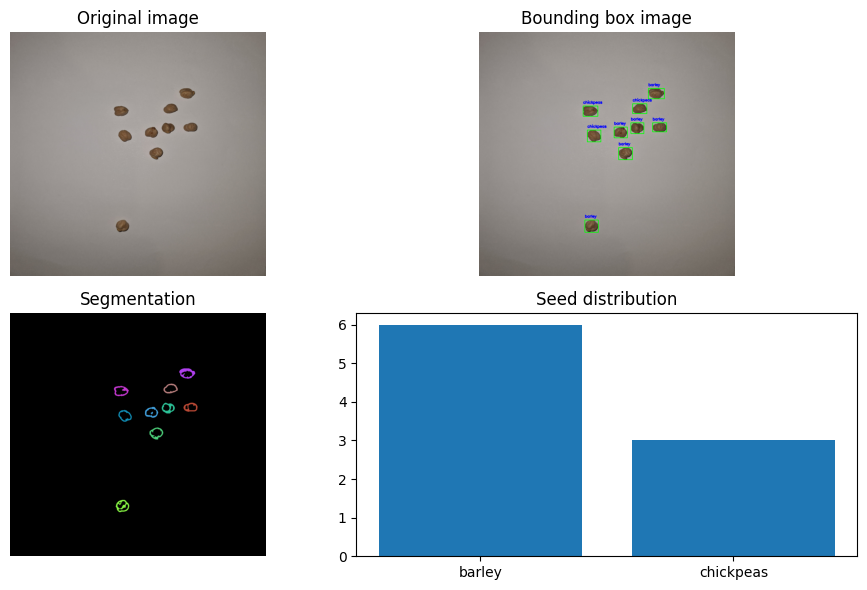

Processing contours:   0%|          | 0/10 [00:00<?, ?it/s]

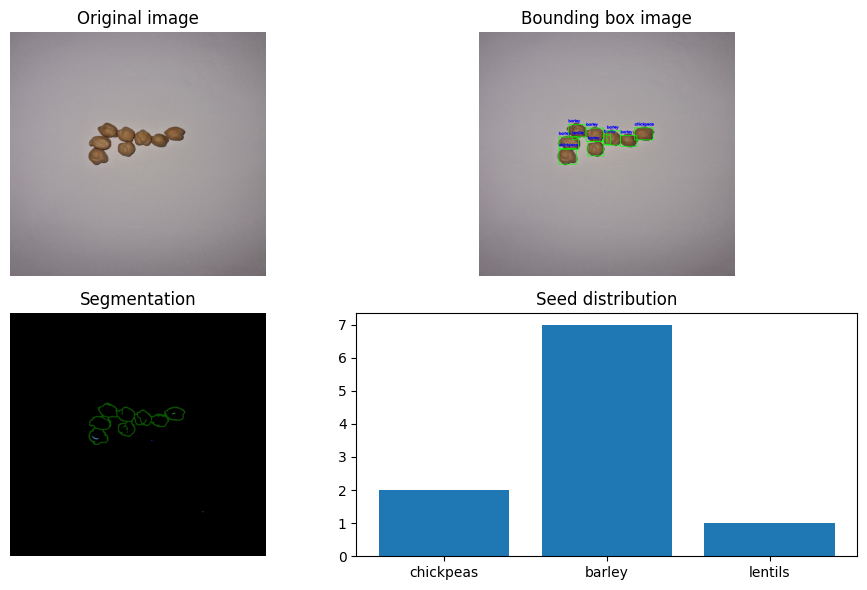

Processing contours:   0%|          | 0/13 [00:00<?, ?it/s]

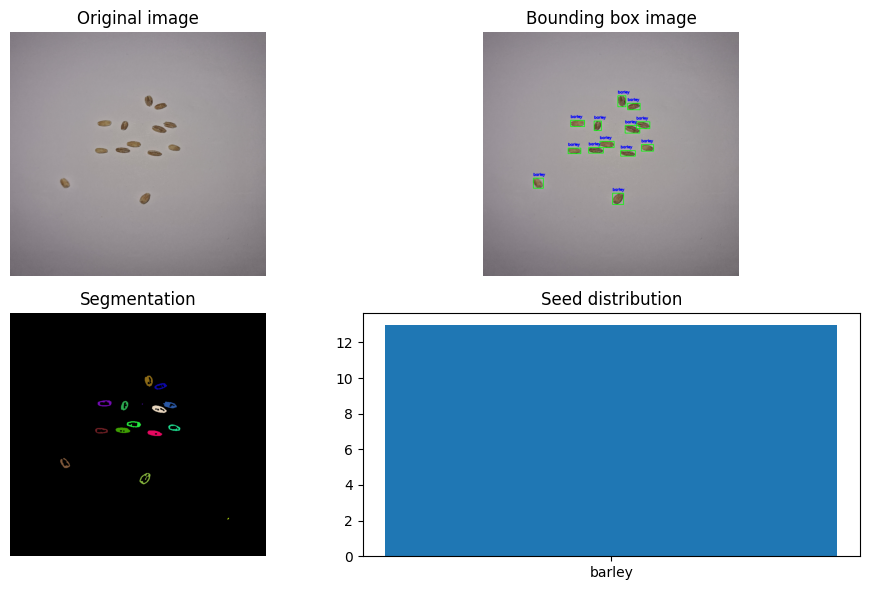

Processing contours:   0%|          | 0/12 [00:00<?, ?it/s]

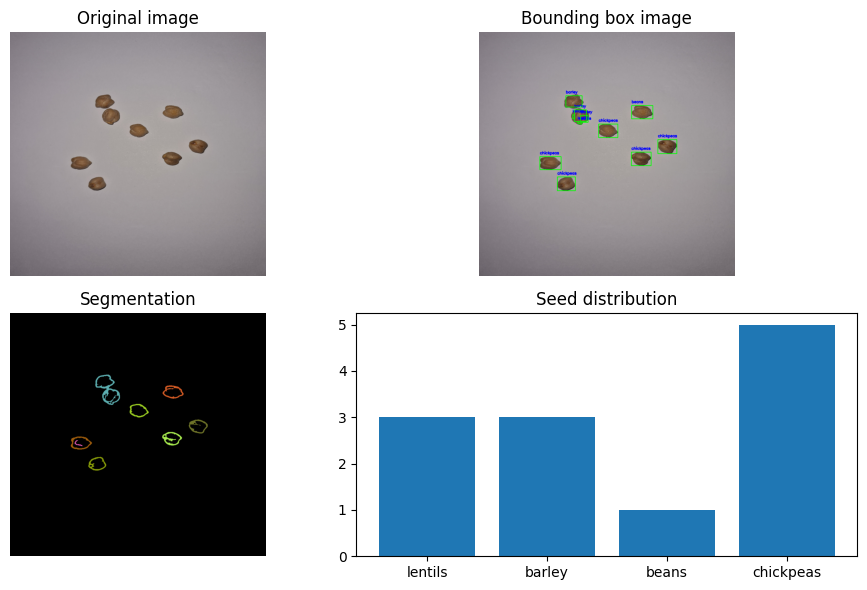

Processing contours:   0%|          | 0/7 [00:00<?, ?it/s]

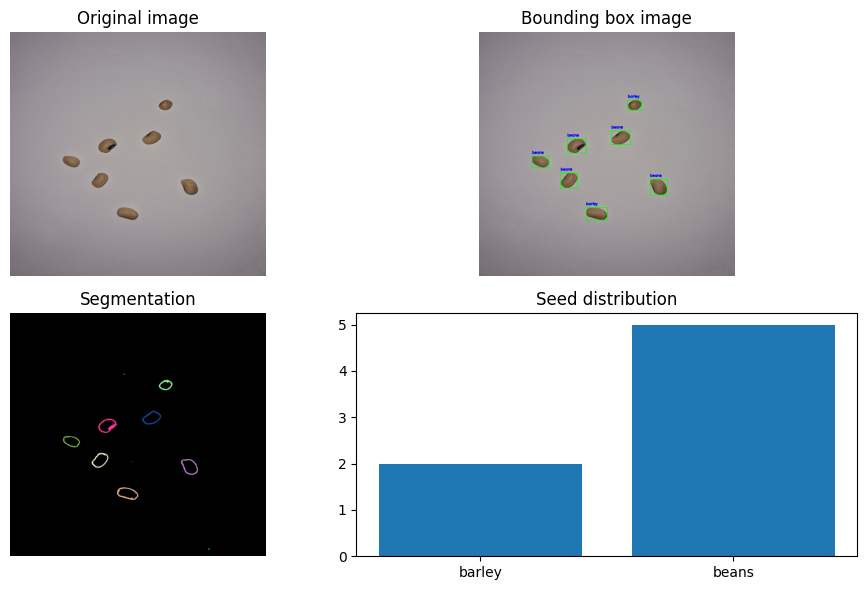

Processing contours:   0%|          | 0/8 [00:00<?, ?it/s]

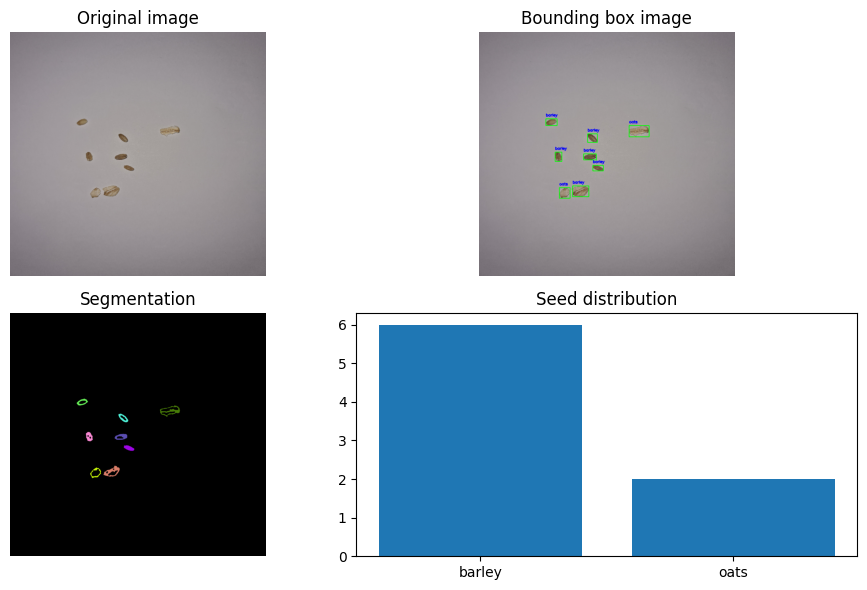

Processing contours:   0%|          | 0/8 [00:00<?, ?it/s]

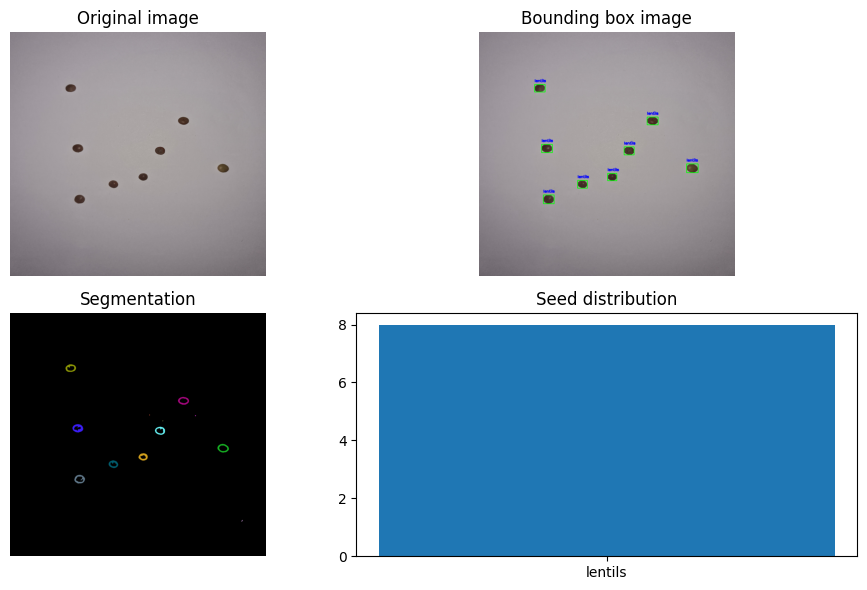

Processing contours:   0%|          | 0/12 [00:00<?, ?it/s]

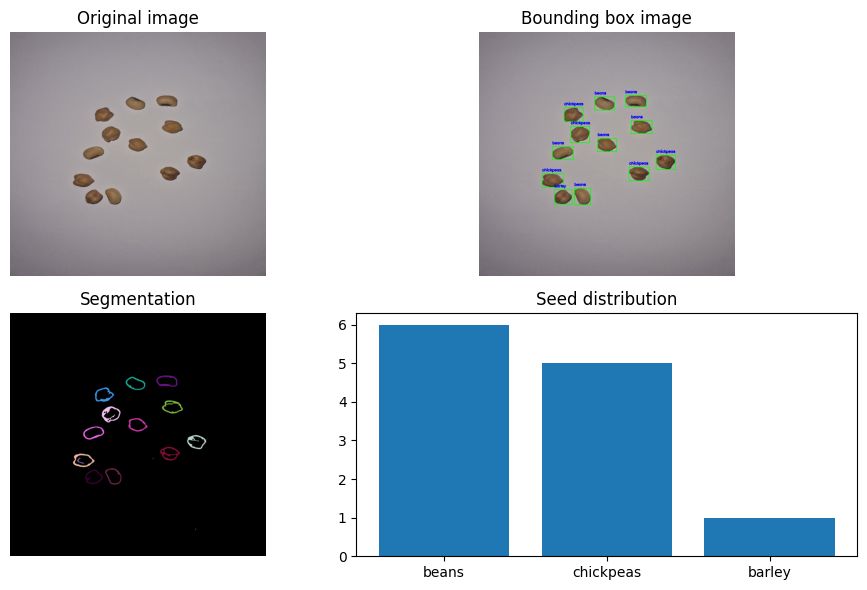

Processing contours:   0%|          | 0/10 [00:00<?, ?it/s]

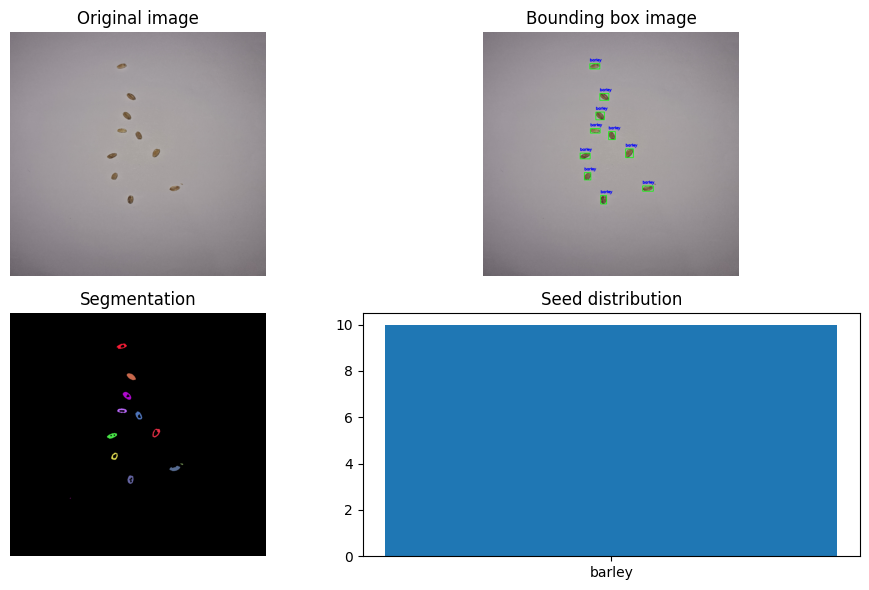

Processing Hard images
These images have a more noisy background and the seeds are harder to see


Processing contours:   0%|          | 0/20 [00:00<?, ?it/s]

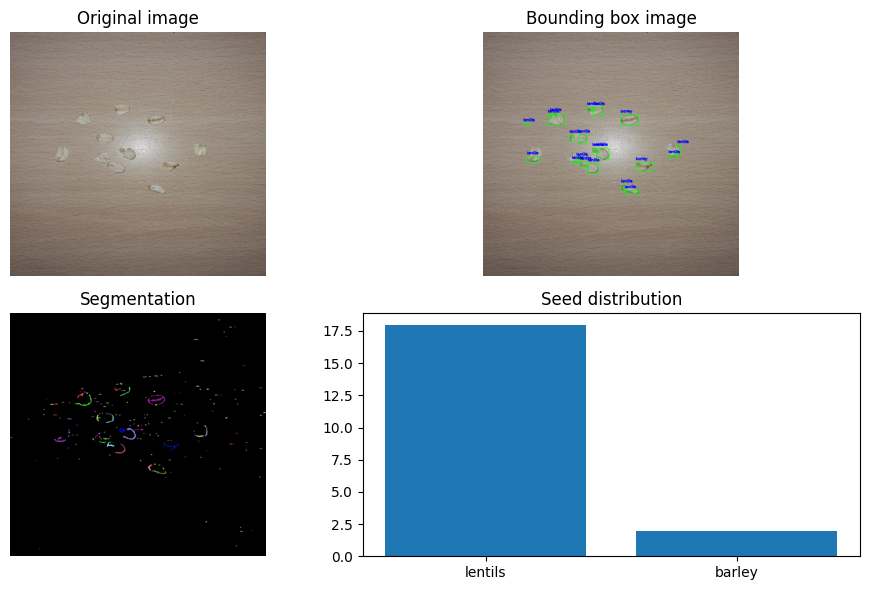

Processing contours:   0%|          | 0/113 [00:00<?, ?it/s]

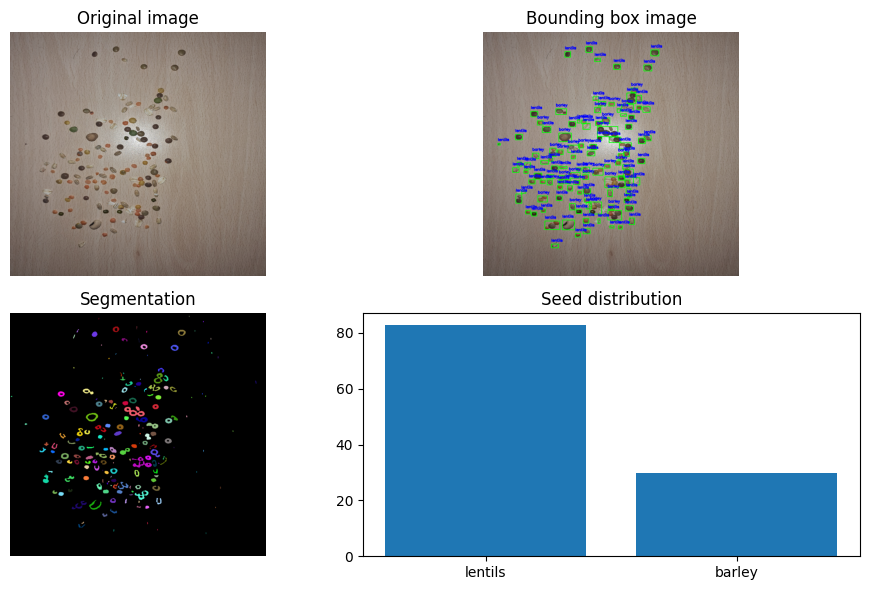

Processing contours:   0%|          | 0/9 [00:00<?, ?it/s]

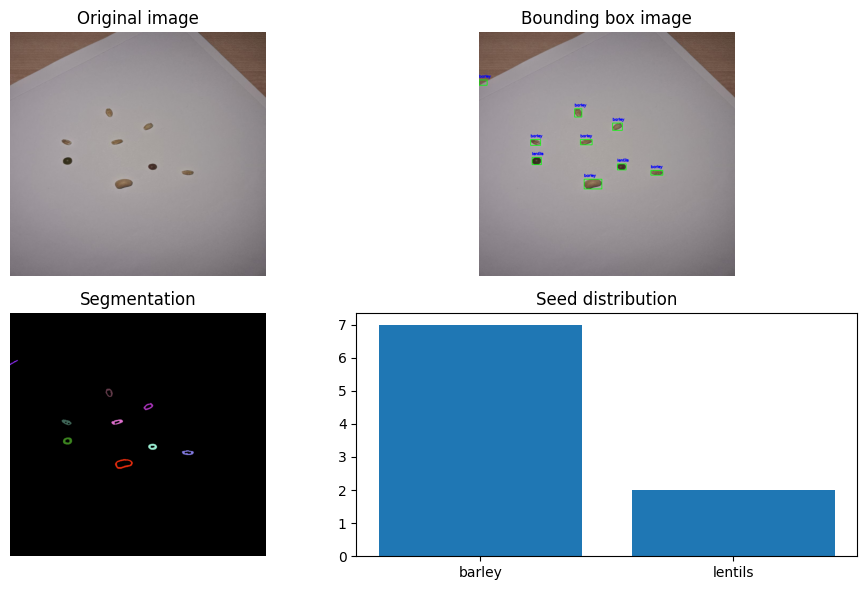

Processing contours:   0%|          | 0/17 [00:00<?, ?it/s]

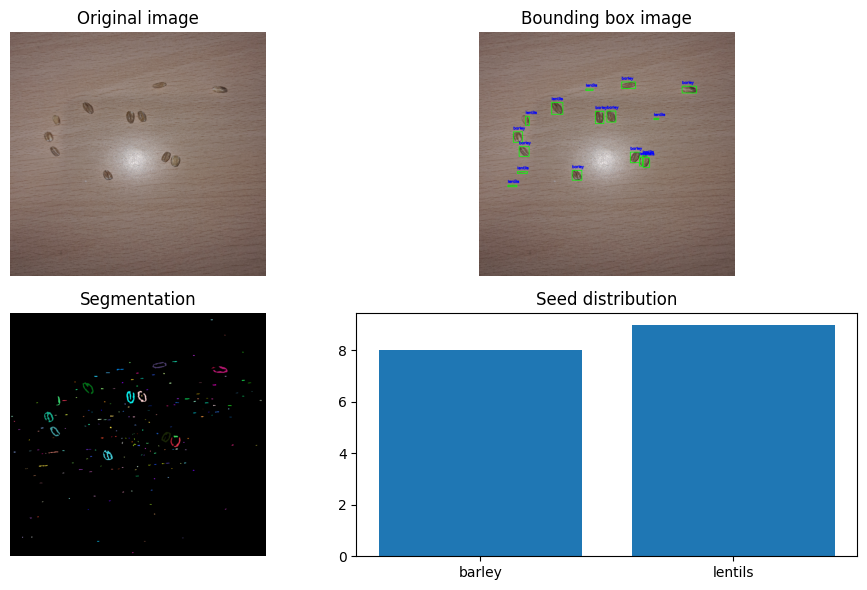

Processing contours:   0%|          | 0/20 [00:00<?, ?it/s]

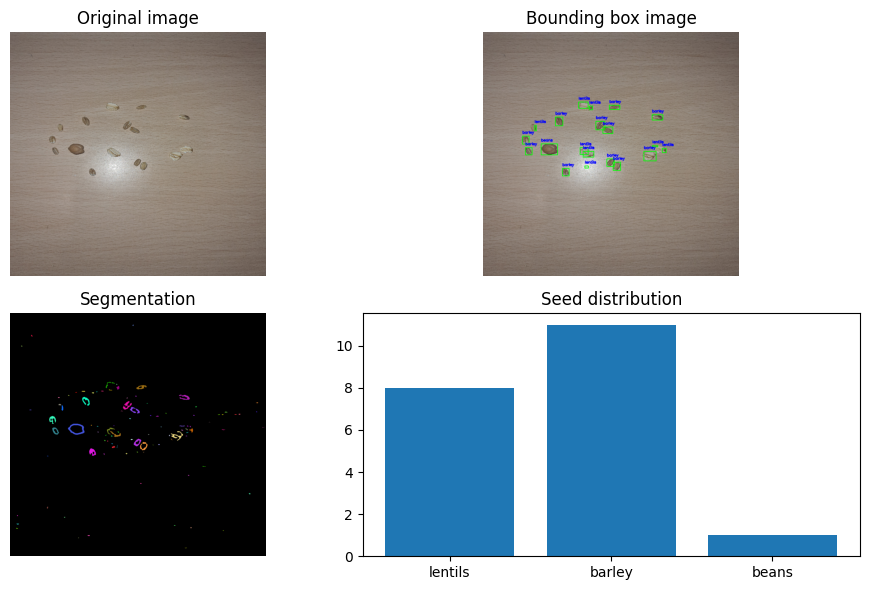

Processing contours:   0%|          | 0/24 [00:00<?, ?it/s]

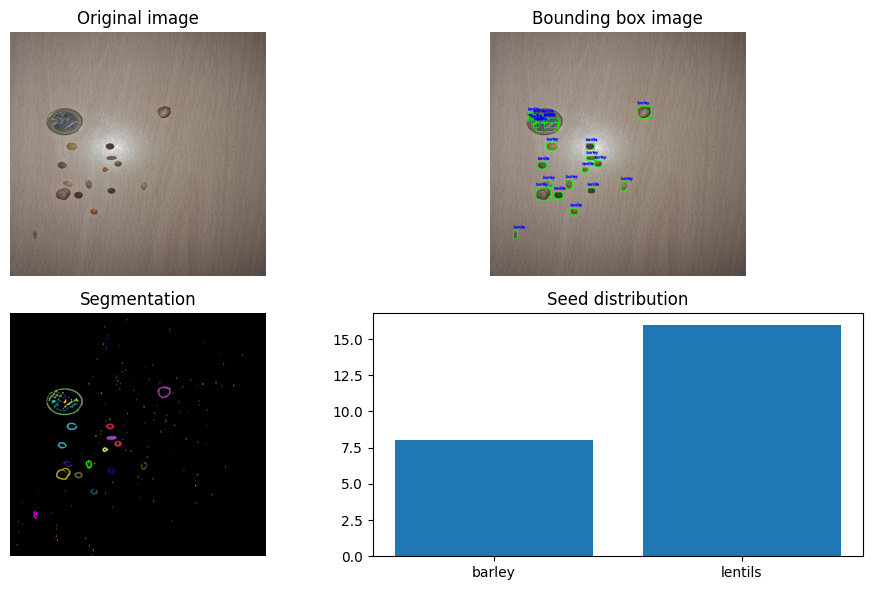

Processing contours:   0%|          | 0/11 [00:00<?, ?it/s]

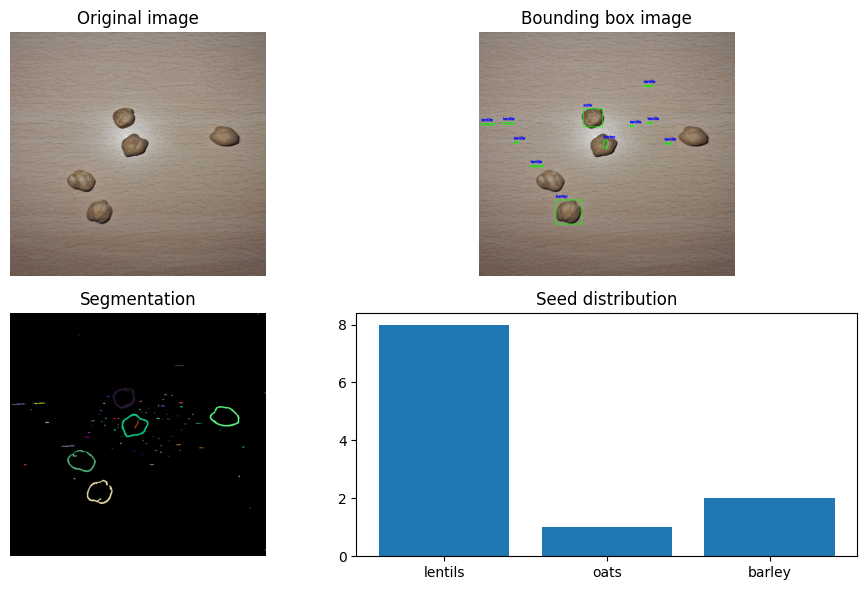

Processing contours:   0%|          | 0/25 [00:00<?, ?it/s]

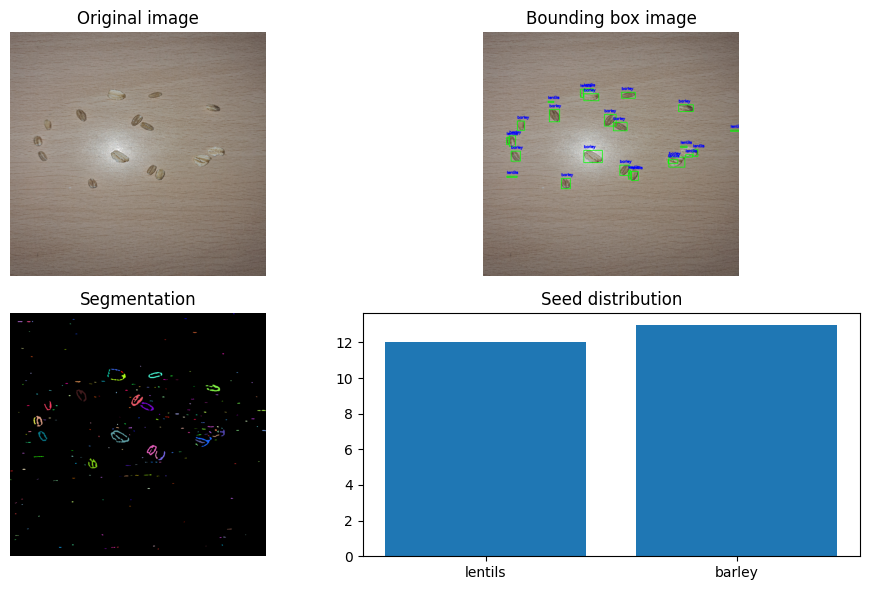

Processing contours:   0%|          | 0/45 [00:00<?, ?it/s]

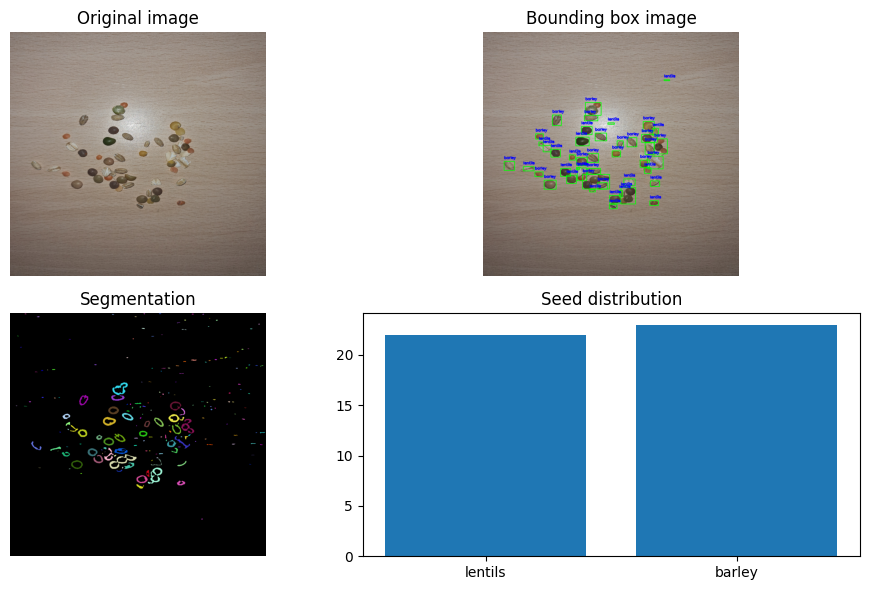

Processing contours:   0%|          | 0/26 [00:00<?, ?it/s]

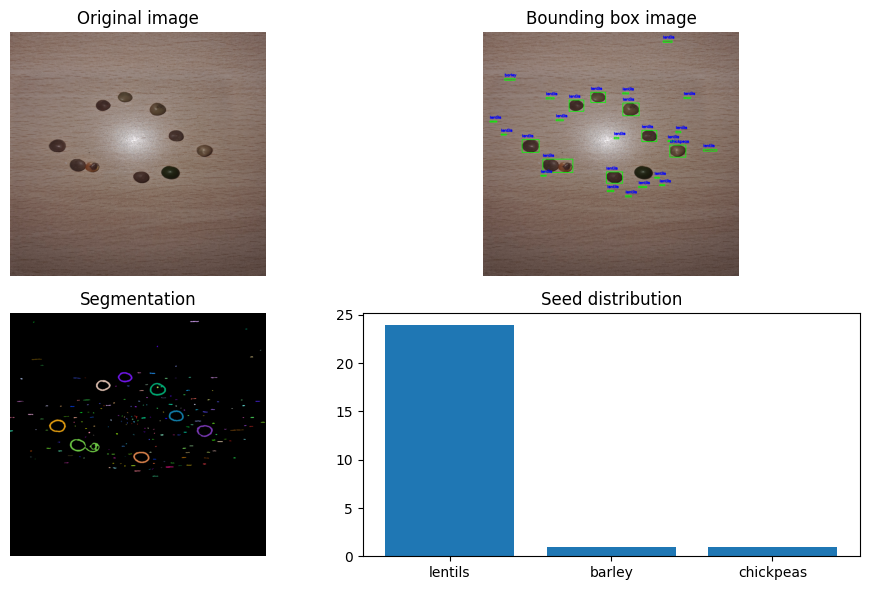

Processing contours:   0%|          | 0/19 [00:00<?, ?it/s]

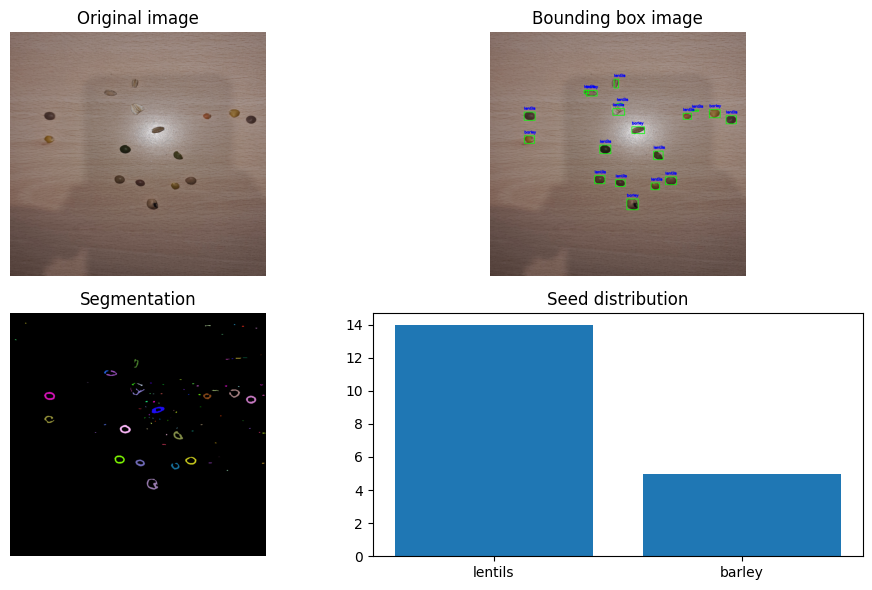

Processing contours:   0%|          | 0/14 [00:00<?, ?it/s]

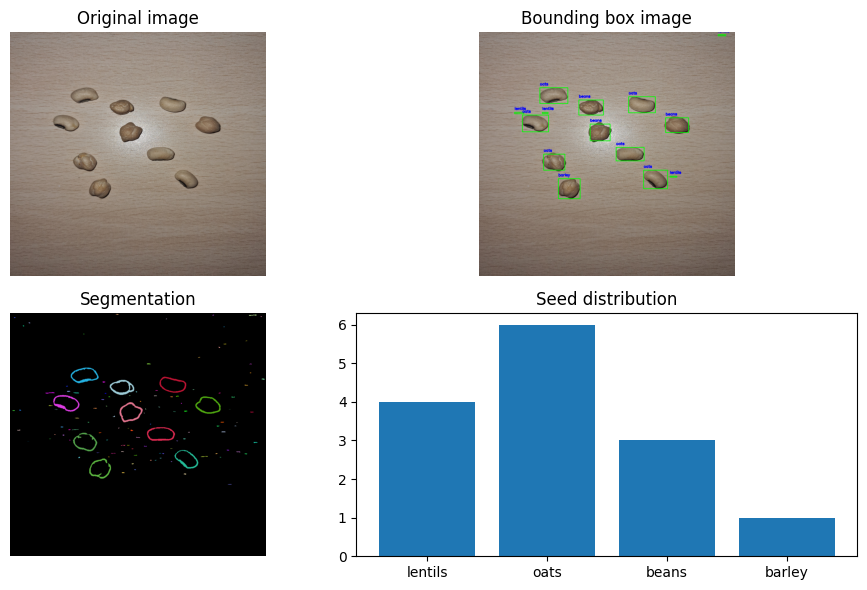

In [4]:
df = pd.read_csv(FEATURE_FILE)
classifier = joblib.load(MODEL)
SIZE = 1024
for difficulty in ['Easy', 'Hard']:
    folder = os.path.join(TEST_FOLDER, difficulty)
    print(f"Processing {difficulty} images")
    if difficulty == 'Easy':
        print("These image have a white background and the seeds are clearly visible")
    else:
        print("These images have a more noisy background and the seeds are harder to see")
    testFiles = os.listdir(folder)
    for file in testFiles:
        img = cv.imread(os.path.join(folder, file))
        img, colored_labels, label_counter, bounding_box_img = pipeline(difficoulty = difficulty, df = df, classifier=classifier, SIZE = SIZE, img = img)
        #make figure have the same height as the image
        fig = plt.figure(figsize=(10, 6))
        axs = fig.subplot_mosaic(
            [["img", "boxes"], ["segmentation", "historgram"]],
            gridspec_kw={"height_ratios": [2, 2]}  # Two rows: images get more space
        )

        axs['img'].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        axs['img'].set_title('Original image')
        axs['img'].axis('off')
        axs['boxes'].imshow(cv.cvtColor(bounding_box_img, cv.COLOR_BGR2RGB))
        axs['boxes'].set_title('Bounding box image')
        axs['boxes'].axis('off')
        axs['segmentation'].imshow(colored_labels)
        axs['segmentation'].set_title('Segmentation')
        axs['segmentation'].axis('off')
        axs['historgram'].bar(label_counter.keys(), label_counter.values())
        axs['historgram'].set_title('Seed distribution')
        plt.tight_layout()
        plt.show()
    